In [20]:
## install packages

#!pip install sentence-transformers faiss-cpu pandas numpy ipywidgets torch

import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import torch
import faiss
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [4]:
!hf auth login --token $INSERTTOKEN --add-to-git-credential

Token is valid (permission: write).
The token `tiffnya` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `tiffnya`


In [6]:
## load and prepare dataset for embeddings
df = pd.read_csv('evaluation.csv')

df["Course A Title"] = df["Course A Title"].fillna("").astype(str)
df["Course A Description"] = df["Course A Description"].fillna("").astype(str)
df["Course B Title"] = df["Course B Title"].fillna("").astype(str)
df["Course B Description"] = df["Course B Description"].fillna("").astype(str)

df["A_text"] = (df["Course A Title"] + ". " + df["Course A Description"])
df["B_text"] = (df["Course B Title"] + ". " + df["Course B Description"])

text_A = df["A_text"].tolist()
text_B = df["B_text"].tolist()
labels = df["Match Label"].fillna(0).astype(int).values

In [19]:
## define models
models_to_test = {
    "bge-base-en-v1.5": "BAAI/bge-base-en-v1.5",
    "e5-large-v2": "intfloat/e5-large-v2",
    "gte-base-en-v1.5": "Alibaba-NLP/gte-base-en-v1.5",
    "mpnet": "sentence-transformers/all-mpnet-base-v2",
    "embeddinggemma-300m": "google/embeddinggemma-300m",
    "jina-v3": "jinaai/jina-embeddings-v3"
}

In [9]:
def optimal_threshold(y_true, y_scores):
    fpr, tpr, thresh = roc_curve(y_true, y_scores)
    J = tpr - fpr
    j_max = np.argmax(J)
    return thresh[j_max]

In [22]:
def evaluate_model(model_name, text_A, text_B, labels, save_emb=True):
    print(f"\nLoading model: {model_name}")
    model = SentenceTransformer(model_name, device=device, trust_remote_code=True)
    model.max_seq_length = 384

    print("Encoding Text A...")
    emb_A = model.encode(text_A, batch_size=32, convert_to_tensor=True, device=device, show_progress_bar=True)
    print("Encoding Text B...")
    emb_B = model.encode(text_B, batch_size=32, convert_to_tensor=True, device=device, show_progress_bar=True)

    emb_A = emb_A.to(torch.float32)
    emb_B = emb_B.to(torch.float32)

    similarity_scores = util.cos_sim(emb_A, emb_B).diagonal().cpu().numpy()

    # calculate model comparison metrics
    # spearman correlation and auc score
    spearman_corr, _ = spearmanr(similarity_scores, labels)
    auc = roc_auc_score((labels > 0).astype(int), similarity_scores)

    # calculate optimal thresholds for classification
    T2 = optimal_threshold((labels == 2).astype(int), similarity_scores)
    T1 = optimal_threshold((labels > 0).astype(int), similarity_scores)

    # calculate accuracy
    pred = np.zeros_like(similarity_scores)
    pred[similarity_scores >= T2] = 2
    pred[(similarity_scores >= T1) & (similarity_scores < T2)] = 1
    pred[similarity_scores < T1] = 0

    acc_equiv = accuracy_score((labels == 2), (pred == 2))
    acc_similar = accuracy_score((labels > 0), (pred > 0))

    # mean similarity per label
    mean_simi_2 = float(np.mean(similarity_scores[labels == 2]))
    mean_simi_1 = float(np.mean(similarity_scores[labels == 1]))
    mean_simi_0 = float(np.mean(similarity_scores[labels == 0]))

    # save embeddings of model
    if save_emb:
        tag = model_name.replace("/", "_")
        np.save(f"{tag}_emb_A.npy", emb_A.cpu().numpy())
        np.save(f"{tag}_emb_B.npy", emb_B.cpu().numpy())

    # cleanup VRAM
    del model, emb_A, emb_B
    torch.cuda.empty_cache()

    return {
        "scores": similarity_scores,
        "pred": pred,
        "true": labels,
        "T1": T1,
        "T2": T2,
        "spearman": spearman_corr,
        "auc": auc,
        "acc_equiv": acc_equiv,
        "acc_similar": acc_similar,
        "mean_simi_2": mean_simi_2,
        "mean_simi_1": mean_simi_1,
        "mean_simi_0": mean_simi_0,
        "confusion_matrix": confusion_matrix(labels, pred),
        "classification_report": classification_report(labels, pred, output_dict=True)
    }

In [24]:
results = {}

for short_name, model_path in models_to_test.items():
    print("\n====================================")
    print(f"Evaluating {short_name}")
    print("====================================")
    results[short_name] = evaluate_model(model_path, text_A, text_B, labels)


Evaluating bge-base-en-v1.5

Loading model: BAAI/bge-base-en-v1.5
Encoding Text A...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Encoding Text B...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating e5-large-v2

Loading model: intfloat/e5-large-v2
Encoding Text A...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Encoding Text B...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating gte-base-en-v1.5

Loading model: Alibaba-NLP/gte-base-en-v1.5
Encoding Text A...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Encoding Text B...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating mpnet

Loading model: sentence-transformers/all-mpnet-base-v2
Encoding Text A...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Encoding Text B...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating embeddinggemma-300m

Loading model: google/embeddinggemma-300m
Encoding Text A...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Encoding Text B...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating jina-v3

Loading model: jinaai/jina-embeddings-v3


Encoding Text A...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Encoding Text B...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
leaderboard = pd.DataFrame([{"model": name,
                             "spearman": res["spearman"],
                             "auc": res["auc"],
                             "equiv_acc": res["acc_equiv"],
                             "similar_acc": res["acc_similar"],
                             "mean_simi_2": res["mean_simi_2"],
                             "mean_simi_1": res["mean_simi_1"],
                             "mean_simi_0": res["mean_simi_0"],
                             "equiv_thr": res["T2"],
                             "similar_thr": res["T1"]} for name, res in results.items()])

leaderboard.sort_values(by="spearman", ascending=False)

,model,spearman,auc,equiv_acc,similar_acc,mean_simi_2,mean_simi_1,mean_simi_0,equiv_thr,similar_thr
0,bge-base-en-v1.5,0.507268,0.912940,0.717105,0.842105,0.800432,0.770835,0.690938,0.808256,0.735461
5,jina-v3,0.486231,0.899090,0.703947,0.881579,0.797838,0.763736,0.644168,0.832461,0.694220
1,e5-large-v2,0.450039,0.877325,0.703947,0.901316,0.892012,0.880858,0.847169,0.904697,0.860280
3,mpnet,0.448455,0.839335,0.690789,0.828947,0.756199,0.708315,0.550908,0.752821,0.644393
4,embeddinggemma-300m,0.424810,0.903839,0.697368,0.710526,0.701253,0.675152,0.551189,0.718193,0.662127
2,gte-base-en-v1.5,0.405391,0.868619,0.677632,0.723684,0.672274,0.633434,0.500403,0.696276,0.615300


In [26]:
## saving data
with open("model_results.pkl", "wb") as f:
    pickle.dump(results, f)

with open("leaderboard.csv", "w") as f:
    leaderboard.to_csv(f, index=False)

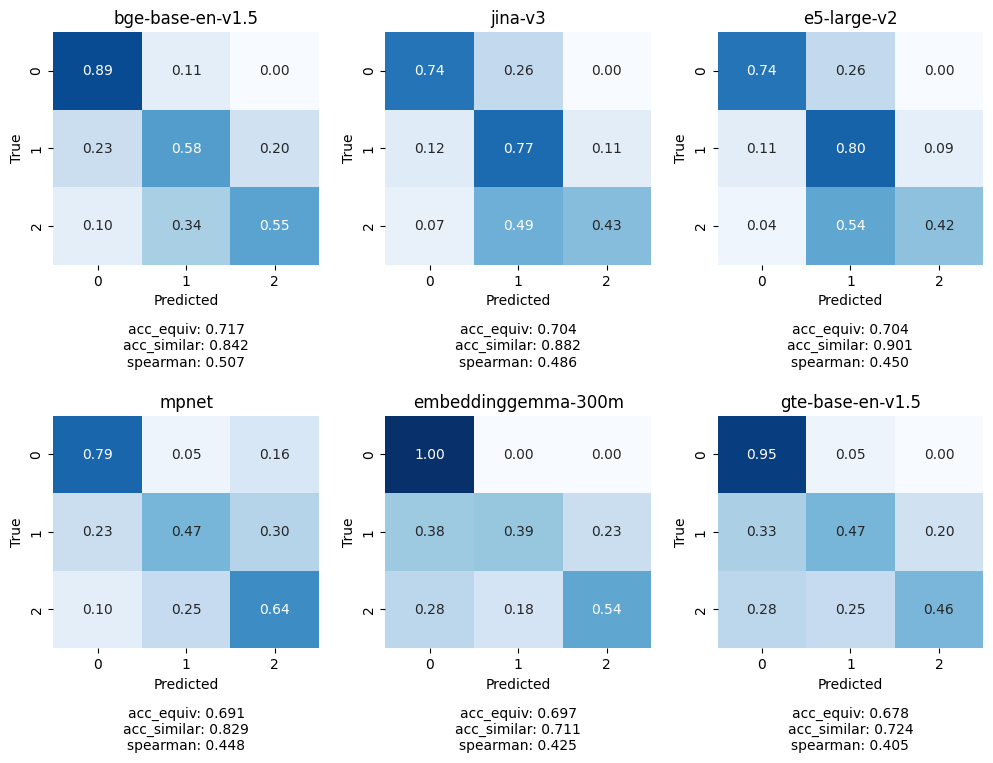

In [27]:
rows = 2
cols = 3

sorted_models = sorted(results.keys(), key=lambda m: results[m]["spearman"], reverse=True)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

for ax, short_name in zip(axes, sorted_models):
    res = results[short_name]
    cm = res["confusion_matrix"]
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=[0,1,2], yticklabels=[0,1,2],
                ax=ax, cbar=False, vmin=0, vmax=1)

    ax.set_title(f"{short_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    metric_text = (
        f"acc_equiv: {res["acc_equiv"]:.3f}\n"
        f"acc_similar: {res["acc_similar"]:.3f}\n"
        f"spearman: {res["spearman"]:.3f}")

    ax.text(0.5, -0.25, metric_text,
            transform=ax.transAxes,
            ha="center", va="top",
            fontsize=10)

plt.subplots_adjust(hspace=0.65, wspace=0.25)
plt.show()
